# SVGP with efficient parametrisation of the variational distribution

This notebook illustrates how to use the equivalent observation framework to get an efficient parametrisation of an GP classification models.

First, let's load some required packages

TODO: 
 * Nice routines for initialising the sparseSVGP (e.g. from prior, from submodel, from ensemble)
 * Move some of the stuff here to a test
 * Experiment: 
    - find dataset
    - proper timing (are they faster to train?)
    - ablation study: with and without warm start for all methods

In [1]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));

M = 50 # number of inducing points
P = 5  # number of models in ensemble  

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We now load the banana dataset: This is a binary classification problem with two classes. 

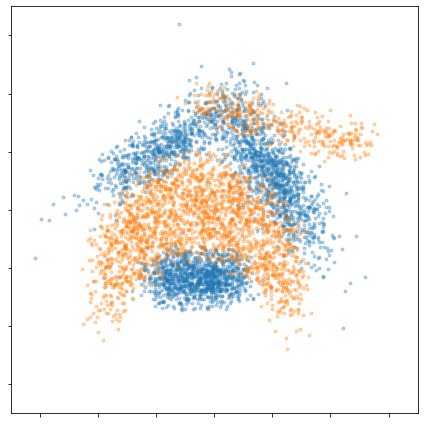

In [2]:
data = sio.loadmat('../../data/banana.mat')
Y = data['banana_Y']
X = data['banana_X']
N = X.shape[0]

x1_lim = [-3.5, 3.5]
x2_lim = [-3.5, 3.5]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.3, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.3, label="$y=1$")

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()

We then split the data in subsets

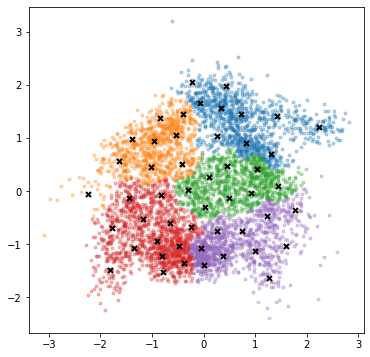

In [3]:
Z, label_x = scipy.cluster.vq.kmeans2(X, M, minit='points')
_, label_z = scipy.cluster.vq.kmeans2(Z, P, minit='points') 
Z_init = Z.copy()

masks_x = np.zeros((N, P), dtype="bool")
masks_z = np.zeros((M, P), dtype="bool")
for i in range(P):
    masks_x[:, i] = label_z[label_x] == i
    masks_z[:, i] = label_z == i

fig, ax = plt.subplots(figsize=(6, 6))
for i in range(P):
    ax.plot(X[masks_x[:, i], 0], X[masks_x[:, i], 1], marker="o", linewidth=0, color=f"C{i}", ms=3, alpha=0.3, label="datapoint class")
    ax.plot(Z[label_z == i, 0], Z[label_z == i, 1], marker="x", linewidth=0, color=f"k", ms=5, mew=2,  alpha=1., label="inducing location")
     

We build an SVGP model for each data subset, with 15 inducing variables for each of them. Note that all submodels share the same kernel and that the kernel parameters are fixed.

In [4]:
kernel = gpflow.kernels.Matern32(variance=50., lengthscales=[3., 3.])
gpflow.set_trainable(kernel, False)
lik = gpflow.likelihoods.Bernoulli()
gpflow.set_trainable(lik, False)
mean_function = gpflow.mean_functions.Zero()

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-08-26 20:00:29.011856: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
M = []
for mask_x, mask_z in zip(masks_x.T, masks_z.T):
    X_ = X[mask_x, :]
    Y_ = Y[mask_x, :]
    Z_ = Z[mask_z, :]

    m = gpflow.models.SVGP(inducing_variable=Z_, likelihood=lik, kernel=kernel, mean_function=mean_function, whiten=False)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss_closure((X_, Y_)), m.trainable_variables);
    M += [m]
    

2022-08-26 20:00:31.680754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's plot the submodels predictions in the data space.

We can now use the equivalent observation framework to merge these four submodels

In [6]:
m_ens = guepard.EquivalentObsEnsemble(M)
Zs = [m.inducing_variable.Z for m in M]
ind_Zi = [0] + list(np.cumsum([Zi.shape[0] for Zi in Zs]))

Z = np.vstack(Zs)
q_m, q_v = m_ens.predict_f(Z, full_cov=True)

inv_noise = np.linalg.inv(q_v[0])-np.linalg.inv(kernel(Z))
q_sigmas = [np.linalg.inv(inv_noise[i:j, i:j]) for i, j in zip(ind_Zi[:-1], ind_Zi[1:])]
q_sqrts = [np.linalg.cholesky(q_sigma)[None, :, :] for q_sigma in q_sigmas]

q_mu = (np.eye(50) + np.linalg.inv(kernel(Z) @ np.linalg.inv(q_v[0]) - np.eye(50))) @ q_m 
q_mus = [q_mu[i:j] for i, j in zip(ind_Zi[:-1], ind_Zi[1:])]


In [8]:
m_ssvgp = guepard.SparseSVGP(kernel, lik, Zs, q_mus=q_mus, q_sqrts=q_sqrts, whiten=False)
m_ssvgp

name,class,transform,prior,trainable,shape,dtype,value
SparseSVGP.kernel.variance,Parameter,Softplus,,False,(),float64,50.0
SparseSVGP.kernel.lengthscales,Parameter,Softplus,,False,"(2,)",float64,[3. 3.]
SparseSVGP.inducing_variable.Z,Parameter,Identity,,True,"(50, 2)",float64,"[[0.55076, 1.63331..."
SparseSVGP.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[2.02390e-01...
SparseSVGP.q_sqrts[0],Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[0.12994, 0., 0...."
SparseSVGP.q_sqrts[1],Parameter,FillTriangular,,True,"(1, 9, 9)",float64,"[[[1.52164e+00, 0.00000e+00, 0.00000e+00..."
SparseSVGP.q_sqrts[2],Parameter,FillTriangular,,True,"(1, 8, 8)",float64,"[[[0.22865, 0., 0...."
SparseSVGP.q_sqrts[3],Parameter,FillTriangular,,True,"(1, 13, 13)",float64,"[[[3.5651e-01, 0.0000e+00, 0.0000e+00..."
SparseSVGP.q_sqrts[4],Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[0.21038, 0., 0...."


Instructions for updating:
Do not call `graph_parents`.


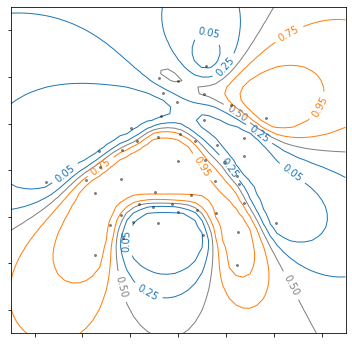

In [9]:
x1_grid = np.linspace(*x1_lim, 50)
x2_grid = np.linspace(*x2_lim, 50)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid) 
Xtest = np.hstack([X1_grid.reshape(-1, 1), X2_grid.reshape(-1, 1)])

Ytest = m_ssvgp.predict_y(Xtest)[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

plt.plot(m_ssvgp.inducing_variable.Z[:, 0], m_ssvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([]);

Compare with an SVGP initialised with the ensemble predictions at Z (they should have the same prediction)

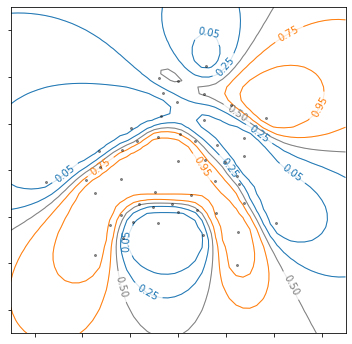

In [10]:
m_ens = guepard.EquivalentObsEnsemble(M)
Z = m_ssvgp.inducing_variable.Z

q_m, q_v = m_ens.predict_f(Z, full_cov=True)
q_s = np.linalg.cholesky(q_v)
m_svgp = gpflow.models.SVGP(inducing_variable=Z, likelihood=lik, kernel=kernel, mean_function=mean_function, q_mu=q_m, q_sqrt=q_s, whiten=False)
   
Ytest_ = m_svgp.predict_y(Xtest)[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest_, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0, alpha=.2)

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

[plt.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4) for m in m_ens.models]
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([]);

In [11]:
q_ms, q_vs = m_ssvgp.predict_f(Xtest, full_cov=False)
q_mo, q_vo = m_ens.predict_f(Xtest, full_cov=False)

print(np.max(np.abs(q_ms - q_mo)))
print(np.max(np.abs(q_vs - q_vo)))

0.0003782276105499527
8.775777791807104e-05


In [12]:
loss = m_ssvgp.training_loss_closure((X, Y), compile=True)
print(loss())

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(loss, m_ssvgp.trainable_variables);

print(loss())

tf.Tensor(1223.2785045591156, shape=(), dtype=float64)
tf.Tensor(1206.4954405901249, shape=(), dtype=float64)


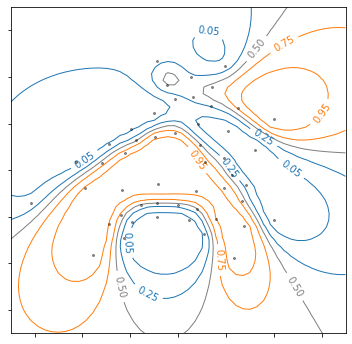

In [13]:
Ytest = m_ssvgp.predict_y(Xtest)[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

plt.plot(m_ssvgp.inducing_variable.Z[:, 0], m_ssvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.set_xticks(np.arange(-3, 4))
ax.set_yticks(np.arange(-3, 4))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([]);

In [14]:
q_mu, q_sigma = m_ssvgp.predict_f(m_ssvgp.inducing_variable.Z, full_cov=True)
q_sqrt = np.linalg.cholesky(q_sigma)

m_fsvgp = gpflow.models.SVGP(
            m_ssvgp.kernel,
            m_ssvgp.likelihood,
            inducing_variable=m_ssvgp.inducing_variable.Z,
            mean_function=m_ssvgp.mean_function,
            q_mu=q_mu,
            q_sqrt=q_sqrt,
            whiten=False,
        )

closure = m_fsvgp.training_loss_closure((X, Y))
print(closure())

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(closure, m_fsvgp.trainable_variables)
print(closure())

Yfsvgp = m_fsvgp.predict_y(Xtest)[0]


tf.Tensor(1206.4960946596038, shape=(), dtype=float64)
tf.Tensor(1206.2149110723774, shape=(), dtype=float64)


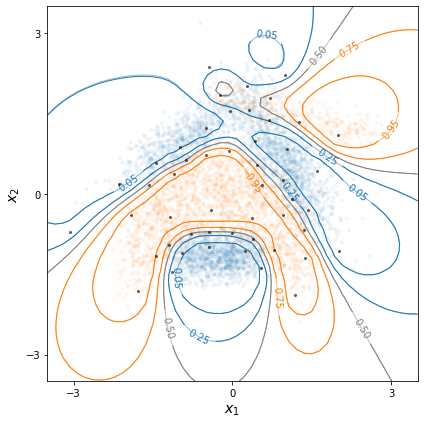

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(Yfsvgp, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0, alpha=.5)

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)

ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

plt.plot(m_ssvgp.inducing_variable.Z[:, 0], m_ssvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)
plt.plot(m_fsvgp.inducing_variable.Z[:, 0], m_fsvgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.2)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.axes.xaxis.set_ticks([-3, 0, 3])
ax.axes.yaxis.set_ticks([-3, 0, 3])

plt.tight_layout()

Train full SVGP without warm start

In [16]:
m_ffsvgp = gpflow.models.SVGP(
            m_ssvgp.kernel,
            m_ssvgp.likelihood,
            inducing_variable=Z_init,
            mean_function=m_ssvgp.mean_function,
            whiten=False,
        )

closure = m_ffsvgp.training_loss_closure((X, Y))
print(closure())

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(closure, m_ffsvgp.trainable_variables)
print(closure())

Yffsvgp = m_ffsvgp.predict_y(Xtest)[0]


tf.Tensor(5238.138497033166, shape=(), dtype=float64)
tf.Tensor(1205.6658017607053, shape=(), dtype=float64)


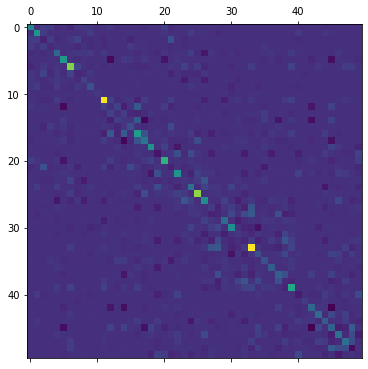

In [19]:
q_m, q_v = m_ffsvgp.predict_f(Z_init, full_cov=True)

inv_noise = np.linalg.inv(q_v[0])-np.linalg.inv(kernel(Z))

plt.matshow(inv_noise)
